In [2078]:
import math, os
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product
from autograd.extend import primitive, defvjp
import meep as mp
import meep.adjoint as mpa
from meep.materials import Ag
import matplotlib.pyplot as plt
import nlopt

mp.verbosity(0)
resolution = 50      # px/µm

lambda0 = 0.5            # [um]
fcen    = 1.0 / lambda0  # [1/um]
width = 0.1
fwidth = fcen*width

nfreq   = 1
frequencies = [fcen]

dpml = 0.5
dair = 1.0
hrod = 0.5     

dsub = 1.0
dAg  = 0.25

sx = 2.121                          # +-3차가 +-45도 나옴
sx = 2.828                          # +-4차가 +-45도 나옴
sy = dpml + dair + hrod + dsub + dAg + dpml
cell_size = mp.Vector3(sx, sy)

wrod = sx

Medium1 = mp.Medium(index = 2.0)
Medium2 = mp.Medium(index = 1.0)

pml_layers = [
    mp.PML(direction=mp.Y, thickness=dpml, side=mp.High),
    mp.PML(direction=mp.Y, thickness=dpml, side=mp.Low)
]

@primitive
def layer_division_2d_autodiff(x_flat, num_layer, Nx, Ny):
    """
    x_flat: (Nx*Ny,) 1D 디자인 벡터
    y 방향으로 num_layer 개로 나누어, 각 레이어 내부를 y축 평균값으로 평탄화함.
    """
    X2 = x_flat.reshape(Nx, Ny)
    Xout = npa.zeros_like(X2)

    # 레이어 높이 계산 (픽셀 단위)
    # 균일하게 나누기 위해 linspace 사용 후 정수로 변환
    layer_boundaries = np.linspace(0, Ny, num_layer + 1).astype(int)

    for i in range(num_layer):
        s, e = layer_boundaries[i], layer_boundaries[i+1]
        if s == e: continue # 혹시라도 해상도가 너무 낮을 경우 대비

        # 해당 레이어 구간 추출 (Nx, thickness)
        seg = X2[:, s:e]
        
        # y축 방향 평균 계산 -> (Nx, 1)
        m = npa.mean(seg, axis=1, keepdims=True)

        # 평균값을 해당 레이어 전체에 브로드캐스팅
        Xout[:, s:e] = npa.broadcast_to(m, seg.shape)

    return Xout.reshape(-1)

def _ld2d_vjp(ans, x_flat, num_layer, Nx, Ny):
    """
    VJP: 레이어 평균화(Mean) 연산의 역전파
    Forward에서 평균을 취했으므로, Backward에서는 Gradient를 
    레이어 픽셀 수(n_elem)로 나누어 분배함.
    """
    def vjp(g_flat):
        g2 = g_flat.reshape(Nx, Ny)
        gout = npa.zeros_like(g2)

        layer_boundaries = np.linspace(0, Ny, num_layer + 1).astype(int)

        for i in range(num_layer):
            s, e = layer_boundaries[i], layer_boundaries[i+1]
            if s == e: continue

            gseg = g2[:, s:e]
            n_elem = float(e - s) # 레이어의 두께(픽셀 수)
            
            # 해당 레이어의 Gradient 합계 계산
            gsum = npa.sum(gseg, axis=1, keepdims=True)

            # Gradient를 입력 픽셀들에 균등 분배
            gout[:, s:e] = npa.broadcast_to(gsum / n_elem, gseg.shape)

        return gout.reshape(-1)

    return vjp

# VJP 등록
defvjp(
    layer_division_2d_autodiff,
    lambda ans, x, num, nx, ny: _ld2d_vjp(ans, x, num, nx, ny),
    argnums=[0] # x_flat에 대해서만 미분
)

DESIGN_W  = wrod
DESIGN_H  = hrod
design_c  = mp.Vector3(0, 0.5*sy - dpml - dAg - dsub - 0.5*hrod)
design_sz = mp.Vector3(DESIGN_W, DESIGN_H)


design_res = resolution
NX = int(DESIGN_W * design_res) + 1

DESIGN_MODE = 'grating'  # or 'free' or 'grating'

if DESIGN_MODE == 'free':
    NY = int(round(DESIGN_H * design_res)) + 1
else:
    # 해상도와 레이어-패딩 조건을 동시에 만족
    DESIRED_LAYERS = 4       # 원하는 레이어 수 (패딩 1픽셀씩 자동)
    NY_min_layers = 2 * DESIRED_LAYERS - 1        # 레이어 L개 + 패딩 L-1개
    NY_res       = int(round(DESIGN_H * design_res))
    NY = max(NY_res, NY_min_layers)

n_vars = NX * NY

# 최소 피쳐/이진화 설정
MIN_FEATURE = 0.09    # ~80 nm
eta_i = 0.55
filter_radius = mpa.get_conic_radius_from_eta_e(MIN_FEATURE, eta_i)

# x = np.ones((n_vars,), dtype=float) * 0.5
np.random.seed(42)

x = np.random.rand(n_vars) * 0.2 + 0.4
# x = np.ones(n_vars)*0.5

design_vars = mp.MaterialGrid(
    mp.Vector3(NX, NY, 0),
    Medium1, Medium2,
    grid_type="U_MEAN",
)
design_region = mpa.DesignRegion(design_vars, volume=mp.Volume(center=design_c, size=design_sz))

# ----------------------------
# geometry (디자인 포함)
# ----------------------------
geometry = [
    mp.Block(
        material=Ag,
        center=mp.Vector3(0, 0.5*sy - dpml - 0.5*dAg),
        size=mp.Vector3(mp.inf, dAg, mp.inf),
    ),
    # Medium1 bulk (Ag 아래에 위치)
    mp.Block(
        material=Medium1,
        center=mp.Vector3(0, 0.5*sy - dpml - dAg - 0.5*dsub),
        size=mp.Vector3(mp.inf, dsub, mp.inf),
    ),
    # Design block (텍스처 영역)
    mp.Block(
        material=design_vars,
        center=design_region.center,
        size=design_region.size,
    ),
]

bottom_pml_top_y = -0.5 * sy + dpml
src_center = mp.Vector3(0, bottom_pml_top_y + (3 / resolution))
src_size   = mp.Vector3(sx, 0, 0)

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=fwidth),
        component=mp.Ez,
        center=mp.Vector3(0, src_center.y),
        size=mp.Vector3(sx, 0)
    )
]

##### 공정 가능한 구조 설계시 #####
def grating_mapping(x, eta, beta):
    global DESIRED_LAYERS

    X = layer_division_2d_autodiff(
            x.ravel(), DESIRED_LAYERS, NX, NY
    )    
    X_2D = X.reshape(NX,NY)
    X_symmetry = 0.5 * (npa.flipud(X_2D) + X_2D)                 # <- 좌우 대칭
    X_projection = mpa.tanh_projection(X_symmetry, beta=beta, eta=eta)
    return X_projection.ravel()


##### 완전한 자유형상 설계시 #####
def free_mapping(x, eta, beta):
    filt = mpa.conic_filter(x, filter_radius, DESIGN_W, DESIGN_H, design_res)   # (NY, NX)
    filt = (npa.flipud(filt) + filt) / 2
    projected_field = mpa.tanh_projection(filt, beta, eta)

    return projected_field.flatten()

##### Mode 선택 #####
mapping = free_mapping if DESIGN_MODE == 'free' else grating_mapping

sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    k_point = mp.Vector3(0,0,0),
    extra_materials=[Ag],
    default_material=mp.Medium(index=1),
)

# --- FourierFields 모니터 (y=0.7 선) ---
ff_center = mp.Vector3(0, 0.7, 0)
ff_size   = mp.Vector3(sx, 0, 0)
ff_vol    = mp.Volume(center=ff_center, size=ff_size)

ff_Ez = mpa.FourierFields(sim, volume=ff_vol, component=mp.Ez)
# -----------------------------------------
# 1) DFT 모니터 설치 (ff_Ez와 동일한 위치/길이)
# -----------------------------------------
dft_line = sim.add_dft_fields([mp.Ez], fcen, 0, 1, center=ff_center, size=ff_size)


margin = 0.4  # [um] 디자인 하단 바로 아래로 살짝 내림

# --- FourierFields 모니터 (y=0.7 선) ---
ff_center = mp.Vector3(0, 0.7, 0)
ff_size   = mp.Vector3(sx, 0, 0)
ff_vol    = mp.Volume(center=ff_center, size=ff_size)

ff_Ez = mpa.FourierFields(sim, volume=ff_vol, component=mp.Ez)

# --- k_x vector 추가 보정 ---
margin = 0.4  # [um] 디자인 하단 바로 아래로 살짝 내림

# 디자인 하단 y좌표
design_bottom_y = design_region.center.y - 0.5 * design_region.size.y

# 추가 모니터의 중심과 크기 (x는 주기 전체 길이)
ff_center_below = mp.Vector3(0, design_bottom_y - margin, 0)
ff_size_below   = mp.Vector3(sx, 0, 0)
ff_vol_below    = mp.Volume(center=ff_center_below, size=ff_size_below)

ff_check_Ez = mpa.FourierFields(sim, volume=ff_vol_below, component=mp.Ez)

# ------------------------------------------------------------
# 단일-bin 인덱스 캐시 (N, m_order가 같으면 항상 같은 bin을 봄)
# ------------------------------------------------------------
_SINGLEBIN_INDEX_CACHE = {}

def _get_singlebin_indices_order(N, m_order):
    """
    FFTSHIFT(FFT(Ez)) 기준으로 회절차수 bin을 '정확히' 고정해서 반환.
    - 0차: i0 = N//2
    - +m차: i0 + m_order
    - -m차: i0 - m_order (필요 시 사용)
    """
    key = (int(N), int(m_order))
    if key in _SINGLEBIN_INDEX_CACHE:
        return _SINGLEBIN_INDEX_CACHE[key]

    i0 = int(N // 2)
    idx_0  = i0
    idx_p  = i0 + int(m_order)
    idx_m  = i0 - int(m_order)

    # 인덱스 범위 체크 (혹시 N이 너무 작으면 방어)
    if not (0 <= idx_m < N and 0 <= idx_0 < N and 0 <= idx_p < N):
        raise ValueError(f"FFT bin index out of range: N={N}, m_order={m_order}")

    _SINGLEBIN_INDEX_CACHE[key] = (idx_0, idx_p, idx_m)
    return idx_0, idx_p, idx_m


def J_kx(Ez_top_line):
    eps = 1e-25
    m_order = 4
    T0, Tp = 0.6, 0.2

    # -----------------------------
    # 1) 입력 Ez 1D
    # -----------------------------
    Ez = npa.ravel(Ez_top_line)

    N_expected = int(round(sx * resolution))
    if Ez.size == N_expected + 1:
        Ez = Ez[:-1]

    N = int(Ez.size)

    # -----------------------------
    # 2) Etgt 합성 (네 정의 유지)
    # -----------------------------
    dx = sx / N
    x = dx * npa.arange(N)

    C0_t = math.sqrt(0.6)
    Cp_t = math.sqrt(0.2)
    Cm_t = math.sqrt(0.2)

    Etgt = (C0_t
            + Cp_t * npa.exp( 1j * 2.0 * npa.pi * m_order * x / sx)
            + Cm_t * npa.exp(-1j * 2.0 * npa.pi * m_order * x / sx))

    # -----------------------------
    # 3) mode overlap (DC 포함 full overlap)
    # -----------------------------
    Fz = npa.fft.fft(Ez)
    Ft = npa.fft.fft(Etgt)

    inner_k = (dx / N) * npa.sum(npa.conj(Ft) * Fz)
    Ez_e2_k = (dx / N) * npa.sum(npa.abs(Fz) ** 2)
    Et_e2_k = (dx / N) * npa.sum(npa.abs(Ft) ** 2)

    J_ov = (npa.abs(inner_k) ** 2) / ((Ez_e2_k + eps) * (Et_e2_k + eps))  # [0,1]

    # =========================================================
    # 4) 단일 bin FFT score (argmin 제거: 완전 고정 인덱스)
    # =========================================================
    idx_0, idx_p4, _ = _get_singlebin_indices_order(N, m_order)

    F = npa.fft.fftshift(npa.fft.fft(Ez))
    P = npa.abs(F) ** 2
    P = P / (npa.sum(P) + eps)  # 합=1

    P0 = P[idx_0]     # 0차 단일 bin
    Pp = P[idx_p4]    # +4차 단일 bin (네가 원한 단일 bin)

    S = P0 + 2.0 * Pp

    # 목표 비율과의 차이(로그 비율)
    ratio_err = npa.log((P0 + eps) / (Pp + eps)) - npa.log(T0 / Tp)

    # 0~1 매핑
    ratio_score = 1.0 / (1.0 + ratio_err ** 2)

    J_fft = ratio_score * S

    # -----------------------------
    # 5) 최종 목적함수 (maximize)
    # -----------------------------
    def harmonic(x, y):
        return 2*x*y/(x+y)
    # J = harmonic(J_ov, J_fft)
    J = J_ov*J_fft
    return J

def smoothmax(x, alpha=80.0, eps=1e-25):
    """
    differentiable max approximation:
      max(x) ~ (1/alpha) * log(sum(exp(alpha*x)))
    alpha가 클수록 max에 더 가까워짐.
    """
    # overflow 방지: x_max 빼고 exp
    x_max = npa.max(x)
    return (1.0 / alpha) * (npa.log(npa.sum(npa.exp(alpha * (x - x_max))) + eps) + alpha * x_max)


def J_kx(Ez_top_line):
    eps = 1e-25
    m_order = 4
    T0, Tp = 0.6, 0.2

    # -----------------------------
    # 1) 입력 Ez 1D
    # -----------------------------
    Ez = npa.ravel(Ez_top_line)

    N_expected = int(round(sx * resolution))
    if Ez.size == N_expected + 1:
        Ez = Ez[:-1]
    N = int(Ez.size)

    # -----------------------------
    # 2) Etgt 합성
    # -----------------------------
    dx = sx / N
    x = dx * npa.arange(N)

    C0_t = math.sqrt(0.6)
    Cp_t = math.sqrt(0.2)
    Cm_t = math.sqrt(0.2)

    Etgt = (C0_t
            + Cp_t * npa.exp( 1j * 2.0 * npa.pi * m_order * x / sx)
            + Cm_t * npa.exp(-1j * 2.0 * npa.pi * m_order * x / sx))

    # -----------------------------
    # 3) overlap (Parseval-정합, FFT 기반)
    # -----------------------------
    Fz = npa.fft.fft(Ez)
    Ft = npa.fft.fft(Etgt)

    inner_k = (dx / N) * npa.sum(npa.conj(Ft) * Fz)
    Ez_e2_k = (dx / N) * npa.sum(npa.abs(Fz) ** 2)
    Et_e2_k = (dx / N) * npa.sum(npa.abs(Ft) ** 2)

    J_ov = (npa.abs(inner_k) ** 2) / ((Ez_e2_k + eps) * (Et_e2_k + eps))  # [0,1]

    # -----------------------------
    # 4) FFT power (sum=1)
    # -----------------------------
    idx_0, idx_p4, idx_m4 = _get_singlebin_indices_order(N, m_order)

    F = npa.fft.fftshift(npa.fft.fft(Ez))
    P = npa.abs(F) ** 2
    P = P / (npa.sum(P) + eps)

    P0 = P[idx_0]
    Pp = P[idx_p4]
    Pm = P[idx_m4]

    # ---- 기존 스펙트럼 점수(네 정의 유지) ----
    S = P0 + 2.0 * Pp
    ratio_err = npa.log((P0 + eps) / (Pp + eps)) - npa.log(T0 / Tp)
    ratio_score = 1.0 / (1.0 + ratio_err ** 2)
    J_fft = ratio_score * S
    J_fft = npa.minimum(npa.maximum(J_fft, 0.0), 1.0)

    # =========================================================
    # 5) minimax leakage penalty (목표 bin 제외 최대 누설 억제)
    # =========================================================
    # 목표 bin(0, ±4) 제외 마스크 만들기
    mask = npa.ones(N, dtype=bool)
    mask = npa.where(npa.arange(N) == idx_0,  False, mask)
    mask = npa.where(npa.arange(N) == idx_p4, False, mask)
    mask = npa.where(npa.arange(N) == idx_m4, False, mask)

    leak_vec = P[mask]                 # 목표 bin 제외한 모든 누설 bin들
    # worst leakage (smooth max)
    alpha = 80.0                       # minimax 강도(클수록 "진짜 max"에 가까움)
    worst_leak = smoothmax(leak_vec, alpha=alpha, eps=eps)  # ~max(leak_vec)

    # 0~1 점수로 변환: worst_leak가 작을수록 점수↑
    J_leak = 1.0 - worst_leak          # [0,1] 범위

    # ---- (선택) leakage를 더 강하게: power weight ----
    gamma_leak = 4.0                   # 1이면 약함, 2~8로 강해짐
    J_leak = (J_leak + eps) ** gamma_leak  # 여전히 [0,1]

    # -----------------------------
    # 6) 최종 목적함수 (0~1)
    # -----------------------------
    J = J_ov * J_fft * J_leak
    J = npa.minimum(npa.maximum(J, 0.0), 1.0)
    return J

def _smoothmax(v, alpha=80.0, eps=1e-25):
    """
    differentiable max approximation:
      max(v) ~ (1/alpha) log(sum(exp(alpha v)))
    alpha가 클수록 실제 max에 가까움.
    """
    v_max = npa.max(v)
    return (1.0/alpha) * (npa.log(npa.sum(npa.exp(alpha * (v - v_max))) + eps) + alpha * v_max)


def _sigmoid(z):
    return 1.0 / (1.0 + npa.exp(-z))


def J_kx(Ez_top_line):
    eps = 1e-25
    m_order = 4
    T0, Tp = 0.6, 0.2

    Ez = npa.ravel(Ez_top_line)
    N_expected = int(round(sx * resolution))
    if Ez.size == N_expected + 1:
        Ez = Ez[:-1]
    N = int(Ez.size)

    # --- Etgt ---
    dx = sx / N
    x = dx * npa.arange(N)

    C0_t = math.sqrt(0.6)
    Cp_t = math.sqrt(0.2)
    Cm_t = math.sqrt(0.2)
    Etgt = (C0_t
            + Cp_t * npa.exp( 1j * 2.0 * npa.pi * m_order * x / sx)
            + Cm_t * npa.exp(-1j * 2.0 * npa.pi * m_order * x / sx))

    # --- overlap (Parseval-정합) ---
    Fz = npa.fft.fft(Ez)
    Ft = npa.fft.fft(Etgt)

    inner_k = (dx / N) * npa.sum(npa.conj(Ft) * Fz)
    Ez_e2_k = (dx / N) * npa.sum(npa.abs(Fz) ** 2)
    Et_e2_k = (dx / N) * npa.sum(npa.abs(Ft) ** 2)
    J_ov = (npa.abs(inner_k) ** 2) / ((Ez_e2_k + eps) * (Et_e2_k + eps))  # [0,1]

    # --- FFT power (sum=1) ---
    idx_0, idx_p4, idx_m4 = _get_singlebin_indices_order(N, m_order)

    F = npa.fft.fftshift(npa.fft.fft(Ez))
    P = npa.abs(F) ** 2
    P = P / (npa.sum(P) + eps)  # sum=1

    P0 = P[idx_0]
    Pp = P[idx_p4]
    Pm = P[idx_m4]

    # =========================================================
    # (A) 기존 J_fft (비율+합) 유지
    # =========================================================
    S = P0 + 2.0 * Pp
    ratio_err = npa.log((P0 + eps) / (Pp + eps)) - npa.log(T0 / Tp)
    ratio_score = 1.0 / (1.0 + ratio_err ** 2)  # (0,1]
    J_fft = ratio_score * S
    J_fft = npa.minimum(npa.maximum(J_fft, 0.0), 1.0)

    # =========================================================
    # (B) "목표 bin이 전체 peak가 되게" 하는 로컬 peak-margin 항
    #     - keep 중 최대 vs others 중 최대의 margin을 키움
    # =========================================================
    # keep: [-4,0,+4] 중 최대값 (smoothmax로 미분 가능)
    alpha_keep = 80.0
    P_keep_max = _smoothmax(npa.array([Pm, P0, Pp]), alpha=alpha_keep, eps=eps)

    # others: 목표 bin을 제외한 나머지 bin들
    mask = npa.ones(N, dtype=bool)
    mask = npa.where(npa.arange(N) == idx_m4, False, mask)
    mask = npa.where(npa.arange(N) == idx_0,  False, mask)
    mask = npa.where(npa.arange(N) == idx_p4, False, mask)

    P_others = P[mask]

    alpha_out = 80.0
    P_out_max = _smoothmax(P_others, alpha=alpha_out, eps=eps)

    # margin이 양수면 목표 bin들이 others보다 큼 -> 원하는 상태
    margin = P_keep_max - P_out_max

    # 0~1 스코어로 매핑 (margin이 클수록 1에 근접)
    # kappa는 "얼마나 예민하게" margin을 반영할지 (너무 크면 날카로워짐)
    kappa = 40.0
    J_peak = _sigmoid(kappa * margin)   # (0,1)

    # =========================================================
    # (C) 최종 (ascent, 0~1 유지)
    # =========================================================
    J = J_ov * J_fft * J_peak
    J = npa.minimum(npa.maximum(J, 0.0), 1.0)
    return J


# ------------------------------------------------------------
# (3) OptimizationProblem에 objective_arguments를 2개로 변경
# ------------------------------------------------------------
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J_kx],
    objective_arguments=[ff_Ez],
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-3,
)

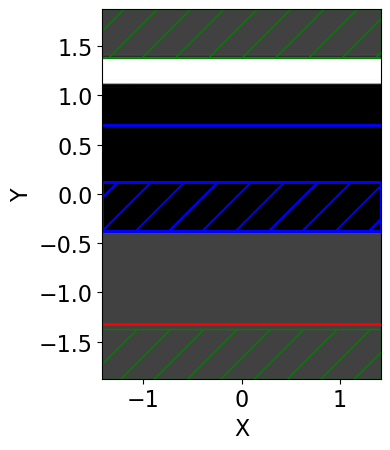

In [2079]:
plt.figure()
opt.plot2D(True)
plt.show()

In [2080]:
evaluation_history = []
binarization_history = []
cur_iter = [0]

##### 최대화/최소화 대상, Gradient Ascent를 사용하기 때문에 양수로 Return #####
def compute_binarization_degree(rho_flat):
        return np.sum(np.abs(rho_flat-0.5)) / (0.5 * rho_flat.size)

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, dJ_du
        )  
    
    ##### 이진화 비율 확인 #####
    rho = mapping(v, eta_i, beta)   # (NX*NY,)
    binarization_degree = compute_binarization_degree(rho)
    
    binarization_history.append(binarization_degree)    
    evaluation_history.append(float(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1
    
    print(f"FOM :{float(np.real(f0))} | Bin Deg : {binarization_degree} | Cur beta : {beta}")
    return float(np.real(f0)) 

In [2034]:
algorithm = nlopt.LD_MMA

lb = np.zeros(n_vars)
ub = np.ones(n_vars)

cur_beta = 4.0
beta_scale = 2.0
num_betas = 10
update_factor = 12
bin_thresh = 0.98

for iters in range(num_betas):
    print("current beta:", cur_beta)

    solver = nlopt.opt(algorithm, n_vars)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)

    x[:] = solver.optimize(x)

    rho = mapping(x, eta_i, cur_beta)   # <-- 중요: v가 아니라 rho로 평가
    bd = compute_binarization_degree(rho)
    print(f"[beta={cur_beta}] binarization degree (rho) = {bd:.4f}")

    if bd >= bin_thresh:
        rho_bin = np.where(np.array(rho) >= 0.5, 1.0, 0.0).astype(float)
        design_vars.update_weights(rho_bin.reshape(NX, NY))

        print(f"[STOP] binarization degree >= {bin_thresh}. Applied hard binarization and stopped.")
        break

    cur_beta *= beta_scale

current beta: 4.0
Current iteration: 1
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.006374416835939369 | Bin Deg : 0.19033413877674143 | Cur beta : 4.0
Current iteration: 2
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.0077315385185054205 | Bin Deg : 0.19040052997669782 | Cur beta : 4.0
Current iteration: 3
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.02049985058499879 | Bin Deg : 0.191017414280889 | Cur beta : 4.0
Current iteration: 4
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6751699903220945 | Bin Deg : 0.20938399274679462 | Cur beta : 4.0
Current iteration: 5
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.0014794926161729178 | Bin Deg : 0.8618967806939958 | Cur beta : 4.0
Current iteration: 6
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.02614911321528979 | Bin Deg : 0.5452108753855248 | Cur beta : 4.0
Current iteration: 7
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.14862844107997336 | Bin Deg : 0.31607503449723073 | Cur beta : 4.0
Current iteration: 8
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6094533922059776 | Bin Deg : 0.22005166942134236 | Cur beta : 4.0
Current iteration: 9
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.736266819972045 | Bin Deg : 0.20978454234456423 | Cur beta : 4.0
Current iteration: 10
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7343421460021606 | Bin Deg : 0.2104924303608417 | Cur beta : 4.0
Current iteration: 11
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7503202150634803 | Bin Deg : 0.20997187949938112 | Cur beta : 4.0
Current iteration: 12
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7484836219062267 | Bin Deg : 0.20980181621543598 | Cur beta : 4.0
[beta=4.0] binarization degree (rho) = 0.2100
current beta: 8.0
Current iteration: 13
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.40551256989693507 | Bin Deg : 0.37587983035146916 | Cur beta : 8.0
Current iteration: 14
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.5109125188282911 | Bin Deg : 0.3733181882504127 | Cur beta : 8.0
Current iteration: 15
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.3518551754531702 | Bin Deg : 0.4139056620196189 | Cur beta : 8.0
Current iteration: 16
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7065333238518375 | Bin Deg : 0.3798382222984178 | Cur beta : 8.0
Current iteration: 17
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.0019496900328985955 | Bin Deg : 0.5209909325833373 | Cur beta : 8.0
Current iteration: 18
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.15308691893540852 | Bin Deg : 0.4131366562806818 | Cur beta : 8.0
Current iteration: 19
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6300784298578251 | Bin Deg : 0.3827664020110499 | Cur beta : 8.0
Current iteration: 20
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7321774070892085 | Bin Deg : 0.3801725639488 | Cur beta : 8.0
Current iteration: 21
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7215269506046033 | Bin Deg : 0.38948425697815303 | Cur beta : 8.0
Current iteration: 22
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7424316014565157 | Bin Deg : 0.3833681133332294 | Cur beta : 8.0
Current iteration: 23
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7479687634682275 | Bin Deg : 0.38323896712252487 | Cur beta : 8.0
Current iteration: 24
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.754229282167685 | Bin Deg : 0.38352258060620736 | Cur beta : 8.0
[beta=8.0] binarization degree (rho) = 0.3835
current beta: 16.0
Current iteration: 25
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6867163588636928 | Bin Deg : 0.5985059765217704 | Cur beta : 16.0
Current iteration: 26
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.07003522599616613 | Bin Deg : 0.5953911302685511 | Cur beta : 16.0
Current iteration: 27
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7169799202318697 | Bin Deg : 0.5978013858369801 | Cur beta : 16.0
Current iteration: 28
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.00035410841174068355 | Bin Deg : 0.6043533657041033 | Cur beta : 16.0
Current iteration: 29
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.40968874419955364 | Bin Deg : 0.5984512368420659 | Cur beta : 16.0
Current iteration: 30
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7295590247439468 | Bin Deg : 0.5978789669981723 | Cur beta : 16.0
Current iteration: 31
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7334302161602445 | Bin Deg : 0.5973901704182492 | Cur beta : 16.0
Current iteration: 32
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6573180580590717 | Bin Deg : 0.5975825523794283 | Cur beta : 16.0
Current iteration: 33
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7126041710966939 | Bin Deg : 0.5974183858769738 | Cur beta : 16.0
Current iteration: 34
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7062814037997888 | Bin Deg : 0.597395696520224 | Cur beta : 16.0
Current iteration: 35
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7335379485082547 | Bin Deg : 0.5973907320148353 | Cur beta : 16.0
Current iteration: 36
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7336067263749289 | Bin Deg : 0.5973910689979212 | Cur beta : 16.0
[beta=16.0] binarization degree (rho) = 0.5974
current beta: 32.0
Current iteration: 37
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.30709848814296414 | Bin Deg : 0.7730644676065931 | Cur beta : 32.0
Current iteration: 38
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.724494784120745 | Bin Deg : 0.7778291045471504 | Cur beta : 32.0
Current iteration: 39
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.09663933464610769 | Bin Deg : 0.8209521217228396 | Cur beta : 32.0
Current iteration: 40
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.5591510592322273 | Bin Deg : 0.7824309230956079 | Cur beta : 32.0
Current iteration: 41
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7089179646722525 | Bin Deg : 0.7781995941342493 | Cur beta : 32.0
Current iteration: 42
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7238801208398176 | Bin Deg : 0.777912877393647 | Cur beta : 32.0
Current iteration: 43
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.725371771528627 | Bin Deg : 0.7778610045355117 | Cur beta : 32.0
Current iteration: 44
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6752467016968751 | Bin Deg : 0.7783254341880316 | Cur beta : 32.0
Current iteration: 45
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7234414910495841 | Bin Deg : 0.7779133323435904 | Cur beta : 32.0
Current iteration: 46
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7255321919834851 | Bin Deg : 0.7778699459148547 | Cur beta : 32.0
Current iteration: 47
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7260294951281042 | Bin Deg : 0.7779766389277363 | Cur beta : 32.0
Current iteration: 48
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7246983725466518 | Bin Deg : 0.7778305259278516 | Cur beta : 32.0
[beta=32.0] binarization degree (rho) = 0.7780
current beta: 64.0
Current iteration: 49
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.686561844635434 | Bin Deg : 0.8900369680101499 | Cur beta : 64.0
Current iteration: 50
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.49035507330279515 | Bin Deg : 0.9000110273250641 | Cur beta : 64.0
Current iteration: 51
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6688383388070596 | Bin Deg : 0.8920510245813938 | Cur beta : 64.0
Current iteration: 52
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7102297478817927 | Bin Deg : 0.8904462508560963 | Cur beta : 64.0
Current iteration: 53
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7268783193309427 | Bin Deg : 0.8882624774870602 | Cur beta : 64.0
Current iteration: 54
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6643273644070772 | Bin Deg : 0.8856318345431107 | Cur beta : 64.0
Current iteration: 55
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7352210077364743 | Bin Deg : 0.8863589512287914 | Cur beta : 64.0
Current iteration: 56
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6937249113126336 | Bin Deg : 0.8854226916928329 | Cur beta : 64.0
Current iteration: 57
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7330492568456461 | Bin Deg : 0.8854129258212418 | Cur beta : 64.0
Current iteration: 58
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7381236026146821 | Bin Deg : 0.8860047026024762 | Cur beta : 64.0
Current iteration: 59
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6969073138598239 | Bin Deg : 0.892393021213503 | Cur beta : 64.0
Current iteration: 60
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7396563689997534 | Bin Deg : 0.8862755159855225 | Cur beta : 64.0
[beta=64.0] binarization degree (rho) = 0.8863
current beta: 128.0
Current iteration: 61
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6831632366758906 | Bin Deg : 0.9441816450847184 | Cur beta : 128.0
Current iteration: 62
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.26937767923486106 | Bin Deg : 0.9611135538649338 | Cur beta : 128.0
Current iteration: 63
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.5748376063676768 | Bin Deg : 0.9477539024572322 | Cur beta : 128.0
Current iteration: 64
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7197374568263988 | Bin Deg : 0.9412817587374421 | Cur beta : 128.0
Current iteration: 65
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7272661973313639 | Bin Deg : 0.9417840410045699 | Cur beta : 128.0
Current iteration: 66
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7349899898729089 | Bin Deg : 0.9402054144435182 | Cur beta : 128.0
Current iteration: 67
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6791923859429787 | Bin Deg : 0.9450476117986539 | Cur beta : 128.0
Current iteration: 68
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7281319754470028 | Bin Deg : 0.9401205989887236 | Cur beta : 128.0
Current iteration: 69
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7358547165383568 | Bin Deg : 0.9401182264443642 | Cur beta : 128.0
Current iteration: 70
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7341174848411528 | Bin Deg : 0.9409000748686299 | Cur beta : 128.0
Current iteration: 71
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7288188257811387 | Bin Deg : 0.9399541172972423 | Cur beta : 128.0
Current iteration: 72
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.736383985187059 | Bin Deg : 0.9400631774048305 | Cur beta : 128.0
[beta=128.0] binarization degree (rho) = 0.9401
current beta: 256.0
Current iteration: 73
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7211515393370669 | Bin Deg : 0.9661836984321902 | Cur beta : 256.0
Current iteration: 74
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.5309516415098063 | Bin Deg : 0.9876636717791168 | Cur beta : 256.0
Current iteration: 75
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6539942270576676 | Bin Deg : 0.9872884628200298 | Cur beta : 256.0
Current iteration: 76
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6846301079474195 | Bin Deg : 0.9792681801235396 | Cur beta : 256.0
Current iteration: 77
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7262182312277822 | Bin Deg : 0.9711573213929237 | Cur beta : 256.0
Current iteration: 78
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7309642583362624 | Bin Deg : 0.9709605946858597 | Cur beta : 256.0
Current iteration: 79
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7319399308861989 | Bin Deg : 0.9701763244610083 | Cur beta : 256.0
Current iteration: 80
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7338833575152546 | Bin Deg : 0.9719826420919213 | Cur beta : 256.0
Current iteration: 81
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7211871178092116 | Bin Deg : 0.9749308385978721 | Cur beta : 256.0
Current iteration: 82
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7346709558881503 | Bin Deg : 0.9721187457107118 | Cur beta : 256.0
Current iteration: 83
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.734894651429179 | Bin Deg : 0.9721926912822746 | Cur beta : 256.0
Current iteration: 84
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7377114605596712 | Bin Deg : 0.9743734843661995 | Cur beta : 256.0
[beta=256.0] binarization degree (rho) = 0.9744
current beta: 512.0
Current iteration: 85
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7333916939331097 | Bin Deg : 0.9887598708310327 | Cur beta : 512.0
Current iteration: 86
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.55262095268421 | Bin Deg : 0.9965642202257914 | Cur beta : 512.0
Current iteration: 87
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.5707151577122885 | Bin Deg : 0.9962988171693129 | Cur beta : 512.0
Current iteration: 88
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.559831529083649 | Bin Deg : 0.993121465551896 | Cur beta : 512.0
Current iteration: 89
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7248367656388858 | Bin Deg : 0.9905773755574689 | Cur beta : 512.0
Current iteration: 90
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7371485812036042 | Bin Deg : 0.9886071207518816 | Cur beta : 512.0
Current iteration: 91
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7188420424540807 | Bin Deg : 0.9890531148529994 | Cur beta : 512.0
Current iteration: 92
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7241618072616975 | Bin Deg : 0.9887668304209242 | Cur beta : 512.0
Current iteration: 93
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7372126788038218 | Bin Deg : 0.9886240201126364 | Cur beta : 512.0
Current iteration: 94
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7239817560687513 | Bin Deg : 0.988862764342266 | Cur beta : 512.0
Current iteration: 95
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7372893121786765 | Bin Deg : 0.9886496279354658 | Cur beta : 512.0
Current iteration: 96
Starting forward run...
Starting adjoint run...
Calculating gradient...
FOM :0.7240621921271726 | Bin Deg : 0.9888697561776418 | Cur beta : 512.0
[beta=512.0] binarization degree (rho) = 0.9886
[STOP] binarization degree >= 0.98. Applied hard binarization and stopped.


AttributeError: 'IndexedSource' object has no attribute 'center'

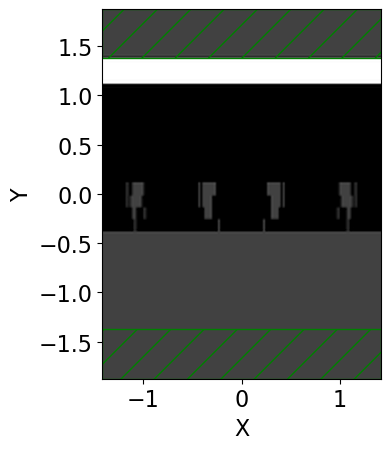

In [2036]:
opt.plot2D()

In [2037]:
np.savetxt("weights_MMA_grat3", design_vars.weights)

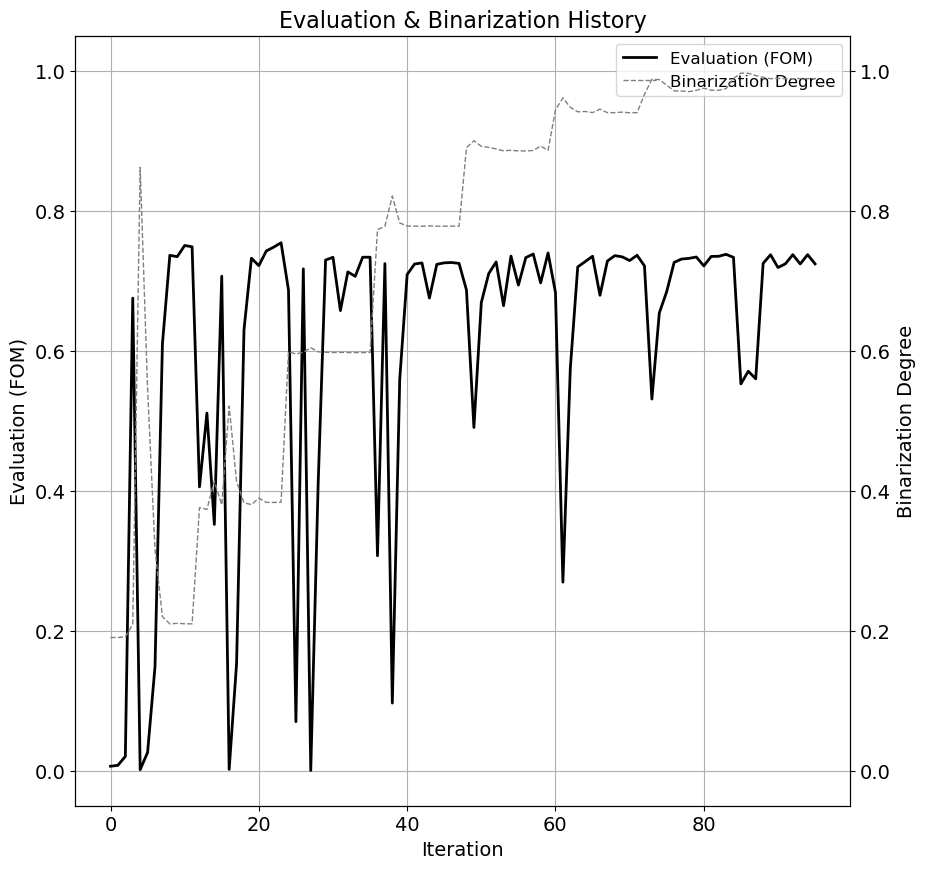

In [2038]:
fig, ax1 = plt.subplots(figsize=(10, 10))

# Title
ax1.set_title("Evaluation & Binarization History", fontsize=16)

# Left y-axis: Evaluation (검정 실선)
ax1.plot(evaluation_history, color="k", linewidth=2, label="Evaluation (FOM)")
ax1.set_xlabel("Iteration", fontsize=14)
ax1.set_ylabel("Evaluation (FOM)", fontsize=14)
ax1.tick_params(axis="both", labelsize=14)
ax1.set_ylim(-0.05,top = 1.05)

# Right y-axis: Binarization (회색 얇은 점선)
ax2 = ax1.twinx()
ax2.plot(binarization_history, color="0.5", linestyle="--", linewidth=1, label="Binarization Degree")
ax2.set_ylabel("Binarization Degree", fontsize=14)
ax2.tick_params(axis="y", labelsize=14)
ax2.set_ylim(-0.05, 1.05)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=12, loc="best")

ax1.grid(True)
plt.show()


In [2081]:
import numpy as np
import math
import jax
import jax.numpy as jnp
import optax
from autograd import numpy as npa

jax.config.update("jax_enable_x64", True)

def adam_maximize_jax(
    v0, n_iter,
    lr_max, lr_min,                # cosine annealing
    beta0, max_beta,
    bin_thresh=0.98,
    beta_schedule="cosine",         # "linear" 또는 "cosine"
):
    """
    JAX(Optax) Adam으로 maximize 수행.
    - beta는 iteration에 따라 beta0 -> max_beta로 gradual하게 증가
    """

    # ---- 초기화 (numpy -> jax) ----
    v_np = np.array(v0, dtype=np.float64).copy()
    params = jnp.array(v_np)

    # ---- cosine annealing lr 스케줄 (기존 유지) ----
    T = max(1, n_iter - 1)
    def lr_schedule(step):
        return lr_min + 0.5 * (lr_max - lr_min) * (1.0 + jnp.cos(jnp.pi * step / T))

    opt = optax.adam(learning_rate=lr_schedule)
    opt_state = opt.init(params)

    def compute_binarization_degree(rho_flat):
        rho_flat = np.asarray(rho_flat, dtype=float).ravel()
        return np.sum(np.abs(rho_flat - 0.5)) / (0.5 * rho_flat.size)

    def beta_at_iter(it):
        """
        it: 0..n_iter-1
        beta0 -> max_beta로 gradual 증가
        """
        t = it / max(1, n_iter - 1)  # 0~1
        if beta_schedule == "linear":
            # 선형 증가
            return beta0 + (max_beta - beta0) * t
        elif beta_schedule == "cosine":
            # cosine ramp: 초반 완만, 후반 가속 (연속/부드러움)
            s = 0.5 * (1.0 - np.cos(np.pi * t))  # 0~1
            return beta0 + (max_beta - beta0) * s
        else:
            raise ValueError("beta_schedule must be 'linear' or 'cosine'")

    for it in range(n_iter):
        # ✅ iteration마다 beta를 연속적으로 증가
        beta = float(beta_at_iter(it))

        # ---- gradient 계산 (maximize 기준: g = dJ/dv) ----
        v_np = np.array(params, dtype=np.float64)
        g = np.zeros_like(v_np)
        _ = f(v_np, g, beta)  # 네 기존 f 그대로 사용

        # maximize -> optax는 descent라 grads=-g
        grads = jnp.array(-g)

        updates, opt_state = opt.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        # bounds
        params = jnp.clip(params, 0.0, 1.0)

        # ---- binarization check (rho 기준) ----
        v_np = np.array(params, dtype=np.float64)
        rho = mapping(v_np, eta_i, beta)
        bin_deg = compute_binarization_degree(rho)

        if bin_deg >= bin_thresh:
            rho_bin = npa.where(npa.asarray(rho) >= 0.5, 1.0, 0.0)
            print(f"[STOP] iter={it+1}, beta={beta:.4g}, bin_deg={bin_deg:.4f} >= {bin_thresh}")
            return np.asarray(rho_bin, dtype=float)

    return np.asarray(params, dtype=float)

v_opt = adam_maximize_jax(
    v0=x,
    n_iter=200,
    lr_max=0.05,
    lr_min=0.01,
    beta0=4,
    max_beta=32,
    bin_thresh=0.98,
    beta_schedule="cosine",   # "linear"로 바꾸면 선형 증가
)


Current iteration: 1
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.008231130596215337 | Bin Deg : 0.19033413877674143 | Cur beta : 4.0
Current iteration: 2
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6969763416493284 | Bin Deg : 0.21885237720991133 | Cur beta : 4.001744546752798
Current iteration: 3
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.15864006350619214 | Bin Deg : 0.24335182685805515 | Cur beta : 4.006977752233567
Current iteration: 4
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7683672337372583 | Bin Deg : 0.21975910217160774 | Cur beta : 4.01569831221779
Current iteration: 5
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8979686901198604 | Bin Deg : 0.21699603978585658 | Cur beta : 4.027904053359093
Current iteration: 6
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.5257603429717187 | Bin Deg : 0.26285487628235427 | Cur beta : 4.043591933730895
Current iteration: 7
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.746990480270581 | Bin Deg : 0.32664527882858163 | Cur beta : 4.062758043584517
Current iteration: 8
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.5224553042783843 | Bin Deg : 0.3760142205306429 | Cur beta : 4.085397606323571
Current iteration: 9
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.5276596377978942 | Bin Deg : 0.4072973586677345 | Cur beta : 4.111504979694391
Current iteration: 10
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7030154751016231 | Bin Deg : 0.43296068172467783 | Cur beta : 4.1410736571922
Current iteration: 11
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7573550992542384 | Bin Deg : 0.45929999318191184 | Cur beta : 4.174096269682668
Current iteration: 12
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7877481417662003 | Bin Deg : 0.4810670816534492 | Cur beta : 4.210564587238453
Current iteration: 13
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8705278299777177 | Bin Deg : 0.50162420204719 | Cur beta : 4.250469521190274
Current iteration: 14
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8747267573812934 | Bin Deg : 0.5216017430819443 | Cur beta : 4.293801126391997
Current iteration: 15
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8731813806518441 | Bin Deg : 0.5381784835612479 | Cur beta : 4.34054860369917
Current iteration: 16
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8925811275186096 | Bin Deg : 0.5532710521032628 | Cur beta : 4.390700302660402
Current iteration: 17
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8980881797846837 | Bin Deg : 0.5671917391405794 | Cur beta : 4.444243724420899
Current iteration: 18
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9024816189074166 | Bin Deg : 0.5802763530047217 | Cur beta : 4.501165524837436
Current iteration: 19
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9281884849621957 | Bin Deg : 0.5931783520816456 | Cur beta : 4.561451517804002
Current iteration: 20
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9075840913416249 | Bin Deg : 0.6054806070771176 | Cur beta : 4.625086678787273
Current iteration: 21
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9131831206821416 | Bin Deg : 0.6168841012404204 | Cur beta : 4.69205514857104
Current iteration: 22
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.883316377237819 | Bin Deg : 0.6272565918580024 | Cur beta : 4.762340237208661
Current iteration: 23
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8878756859822587 | Bin Deg : 0.6372616357705743 | Cur beta : 4.835924428182542
Current iteration: 24
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8909178572433591 | Bin Deg : 0.6464220089715618 | Cur beta : 4.912789382769623
Current iteration: 25
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9086984735938262 | Bin Deg : 0.654931407539301 | Cur beta : 4.992915944611772
Current iteration: 26
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9245981713278809 | Bin Deg : 0.6627404035315593 | Cur beta : 5.07628414448995
Current iteration: 27
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9003883537278367 | Bin Deg : 0.6699114867163877 | Cur beta : 5.162873205300957
Current iteration: 28
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9077726653916812 | Bin Deg : 0.6773466209902582 | Cur beta : 5.25266154723553
Current iteration: 29
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9420253089200715 | Bin Deg : 0.6848337822534312 | Cur beta : 5.3456267931564705
Current iteration: 30
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9456833535184223 | Bin Deg : 0.6920062536231406 | Cur beta : 5.44174577417551
Current iteration: 31
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.935940817887172 | Bin Deg : 0.6983781832260733 | Cur beta : 5.540994535427475
Current iteration: 32
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9373368030263765 | Bin Deg : 0.7043865885746813 | Cur beta : 5.643348342040343
Current iteration: 33
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9451034783949162 | Bin Deg : 0.7103296350836792 | Cur beta : 5.748781685299688
Current iteration: 34
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.94463252349537 | Bin Deg : 0.7166135156985358 | Cur beta : 5.8572682890059955
Current iteration: 35
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9434445855380673 | Bin Deg : 0.7227629356264968 | Cur beta : 5.968781116023232
Current iteration: 36
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9496687141842617 | Bin Deg : 0.7289409471662506 | Cur beta : 6.083292375017075
Current iteration: 37
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.961337637693047 | Bin Deg : 0.734801177102275 | Cur beta : 6.2007735273810916
Current iteration: 38
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9605332820809307 | Bin Deg : 0.740487016644805 | Cur beta : 6.321195294349154
Current iteration: 39
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9617643356598359 | Bin Deg : 0.7459746269812952 | Cur beta : 6.444527664292333
Current iteration: 40
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9669428231361381 | Bin Deg : 0.7519154806472312 | Cur beta : 6.5707399001984115
Current iteration: 41
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9690163824254009 | Bin Deg : 0.758273871258355 | Cur beta : 6.699800547332205
Current iteration: 42
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9693351831670411 | Bin Deg : 0.7644980711884275 | Cur beta : 6.83167744107473
Current iteration: 43
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9731289272013397 | Bin Deg : 0.7701655149532679 | Cur beta : 6.966337714939306
Current iteration: 44
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9749889674706632 | Bin Deg : 0.7752791731452102 | Cur beta : 7.103747808762581
Current iteration: 45
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.96360091921532 | Bin Deg : 0.7802310298401419 | Cur beta : 7.24387347706841
Current iteration: 46
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9695926281446768 | Bin Deg : 0.7848402415875535 | Cur beta : 7.3866797976025635
Current iteration: 47
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9623522611847174 | Bin Deg : 0.7897156519742009 | Cur beta : 7.532131180036072
Current iteration: 48
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9632382112916142 | Bin Deg : 0.7946111305811798 | Cur beta : 7.680191374835093
Current iteration: 49
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9649955841764235 | Bin Deg : 0.7990782828102665 | Cur beta : 7.830823482295048
Current iteration: 50
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9705942442644673 | Bin Deg : 0.8037818399939866 | Cur beta : 7.9839899617368015
Current iteration: 51
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9740281785052728 | Bin Deg : 0.8086225311373201 | Cur beta : 8.139652640862588
Current iteration: 52
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9736708158837648 | Bin Deg : 0.8139360068213175 | Cur beta : 8.297772725269356
Current iteration: 53
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9749397538163718 | Bin Deg : 0.8183488409573713 | Cur beta : 8.458310808117128
Current iteration: 54
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.977116555348254 | Bin Deg : 0.822141755936868 | Cur beta : 8.621226879950026
Current iteration: 55
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9725281665223706 | Bin Deg : 0.8259399841933144 | Cur beta : 8.786480338667472
Current iteration: 56
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.979399853534372 | Bin Deg : 0.8303092709821368 | Cur beta : 8.954029999643062
Current iteration: 57
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.981955250878429 | Bin Deg : 0.834851926984825 | Cur beta : 9.123834105988658
Current iteration: 58
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9807821706811276 | Bin Deg : 0.8389352503851004 | Cur beta : 9.295850338961067
Current iteration: 59
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9825807715297743 | Bin Deg : 0.842678322642136 | Cur beta : 9.470035828508765
Current iteration: 60
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9853231665650195 | Bin Deg : 0.8460275641814072 | Cur beta : 9.646347163956017
Current iteration: 61
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9852408775827907 | Bin Deg : 0.8491490672139322 | Cur beta : 9.824740404821712
Current iteration: 62
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9735531498543848 | Bin Deg : 0.8530003206251241 | Cur beta : 10.005171091770274
Current iteration: 63
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9750610325771742 | Bin Deg : 0.8570535341485058 | Cur beta : 10.187594257691838
Current iteration: 64
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9727340618448723 | Bin Deg : 0.8616331519515278 | Cur beta : 10.371964438909014
Current iteration: 65
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9767302630006429 | Bin Deg : 0.8647367488434857 | Cur beta : 10.55823568650738
Current iteration: 66
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.985795971930415 | Bin Deg : 0.8663616607070458 | Cur beta : 10.746361577786917
Current iteration: 67
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9873333703585417 | Bin Deg : 0.8668472869965261 | Cur beta : 10.936295227831515
Current iteration: 68
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9813055424130177 | Bin Deg : 0.8698573125019223 | Cur beta : 11.12798930119369
Current iteration: 69
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9791663581037122 | Bin Deg : 0.8734725028969005 | Cur beta : 11.321396023691543
Current iteration: 70
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9892608929712101 | Bin Deg : 0.8767994882579756 | Cur beta : 11.516467194315132
Current iteration: 71
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9865097088254895 | Bin Deg : 0.8803791448476552 | Cur beta : 11.713154197239117
Current iteration: 72
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9851757082133507 | Bin Deg : 0.8833899456364637 | Cur beta : 11.911408013938896
Current iteration: 73
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9843212924111494 | Bin Deg : 0.8859771145966048 | Cur beta : 12.111179235407022
Current iteration: 74
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9826510929916354 | Bin Deg : 0.8884488438811279 | Cur beta : 12.312418074466953
Current iteration: 75
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9829813112472163 | Bin Deg : 0.8904240039541557 | Cur beta : 12.515074378181096
Current iteration: 76
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9869500366304091 | Bin Deg : 0.8918057707752407 | Cur beta : 12.719097640349935
Current iteration: 77
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9867133764703174 | Bin Deg : 0.8928011050547241 | Cur beta : 12.924437014099254
Current iteration: 78
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9859784071328161 | Bin Deg : 0.894186887214101 | Cur beta : 13.131041324552246
Current iteration: 79
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9873223941286647 | Bin Deg : 0.8956010527025465 | Cur beta : 13.33885908158334
Current iteration: 80
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9891824666614161 | Bin Deg : 0.8965223848907772 | Cur beta : 13.547838492650666
Current iteration: 81
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9847329946054639 | Bin Deg : 0.897338053356748 | Cur beta : 13.75792747570378
Current iteration: 82
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9882113295137223 | Bin Deg : 0.8987501221126402 | Cur beta : 13.969073672163667
Current iteration: 83
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9891142173642876 | Bin Deg : 0.9007194407866977 | Cur beta : 14.181224459971554
Current iteration: 84
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9896051551339337 | Bin Deg : 0.9025393840711882 | Cur beta : 14.394326966703444
Current iteration: 85
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9907920875288684 | Bin Deg : 0.9040957674774932 | Cur beta : 14.608328082747034
Current iteration: 86
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9878105207425553 | Bin Deg : 0.9062633780521332 | Cur beta : 14.823174474537739
Current iteration: 87
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9854207320092646 | Bin Deg : 0.9091208030428767 | Cur beta : 15.038812597850534
Current iteration: 88
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9856637126756964 | Bin Deg : 0.9115190112302575 | Cur beta : 15.255188711144307
Current iteration: 89
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9856537958594471 | Bin Deg : 0.9128499687010688 | Cur beta : 15.47224888895537
Current iteration: 90
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9881375239811405 | Bin Deg : 0.913711365983992 | Cur beta : 15.689939035336808
Current iteration: 91
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9865030315057314 | Bin Deg : 0.9156905733806792 | Cur beta : 15.908204897340346
Current iteration: 92
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9852238424305086 | Bin Deg : 0.9183170799342762 | Cur beta : 16.12699207853729
Current iteration: 93
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9860931272711567 | Bin Deg : 0.9207142225959254 | Cur beta : 16.34624605257529
Current iteration: 94
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9867453820254061 | Bin Deg : 0.9218725279055375 | Cur beta : 16.565912176767416
Current iteration: 95
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9918181957335195 | Bin Deg : 0.922496625854063 | Cur beta : 16.785935705710287
Current iteration: 96
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9862037996776073 | Bin Deg : 0.9243434277040934 | Cur beta : 17.006261804927778
Current iteration: 97
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9906542649913497 | Bin Deg : 0.9264405216304634 | Cur beta : 17.226835564536884
Current iteration: 98
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9916205671261902 | Bin Deg : 0.9279143572864689 | Cur beta : 17.44760201293246
Current iteration: 99
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9903632973093349 | Bin Deg : 0.9288462557906919 | Cur beta : 17.668506130487266
Current iteration: 100
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9927878748962414 | Bin Deg : 0.9303147193077215 | Cur beta : 17.88949286326401
Current iteration: 101
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9933571205898568 | Bin Deg : 0.9319990626718669 | Cur beta : 18.110507136735983
Current iteration: 102
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9872840672844582 | Bin Deg : 0.9329878818576168 | Cur beta : 18.331493869512734
Current iteration: 103
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.987623951370971 | Bin Deg : 0.9336667210315167 | Cur beta : 18.55239798706754
Current iteration: 104
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9878936350051496 | Bin Deg : 0.9347730632022613 | Cur beta : 18.773164435463112
Current iteration: 105
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9880183915208093 | Bin Deg : 0.9364193649137676 | Cur beta : 18.993738195072222
Current iteration: 106
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9899402897798992 | Bin Deg : 0.937837351637299 | Cur beta : 19.21406429428971
Current iteration: 107
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9895609087843797 | Bin Deg : 0.9382043679039908 | Cur beta : 19.43408782323258
Current iteration: 108
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9869488836799812 | Bin Deg : 0.9386150363809427 | Cur beta : 19.65375394742471
Current iteration: 109
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9883375500078746 | Bin Deg : 0.9392518447727003 | Cur beta : 19.873007921462705
Current iteration: 110
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9879386784117634 | Bin Deg : 0.9401716299035043 | Cur beta : 20.091795102659653
Current iteration: 111
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9881070936637805 | Bin Deg : 0.9409294093595041 | Cur beta : 20.310060964663187
Current iteration: 112
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9917059061931119 | Bin Deg : 0.9415925539498806 | Cur beta : 20.52775111104463
Current iteration: 113
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9915327481632586 | Bin Deg : 0.9418503307745882 | Cur beta : 20.744811288855693
Current iteration: 114
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9819668357221722 | Bin Deg : 0.9429182735470001 | Cur beta : 20.961187402149463
Current iteration: 115
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9877692250070754 | Bin Deg : 0.9446632659289771 | Cur beta : 21.176825525462263
Current iteration: 116
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.981652294315143 | Bin Deg : 0.9459967234565274 | Cur beta : 21.391671917252964
Current iteration: 117
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9907819599276871 | Bin Deg : 0.9462813623838159 | Cur beta : 21.60567303329655
Current iteration: 118
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9836977895435073 | Bin Deg : 0.947380406551295 | Cur beta : 21.818775540028444
Current iteration: 119
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9883067625052141 | Bin Deg : 0.9500457125927765 | Cur beta : 22.03092632783633
Current iteration: 120
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9846374751983115 | Bin Deg : 0.95166134321401 | Cur beta : 22.24207252429622
Current iteration: 121
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9835074751100251 | Bin Deg : 0.9519902134389798 | Cur beta : 22.452161507349334
Current iteration: 122
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9882821782852272 | Bin Deg : 0.9518978852122699 | Cur beta : 22.661140918416653
Current iteration: 123
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9884517568374145 | Bin Deg : 0.9519750729766471 | Cur beta : 22.868958675447754
Current iteration: 124
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9898999642277974 | Bin Deg : 0.953380899571423 | Cur beta : 23.075562985900742
Current iteration: 125
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9874764968274748 | Bin Deg : 0.9548275320473308 | Cur beta : 23.280902359650064
Current iteration: 126
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9871570239560431 | Bin Deg : 0.9558265968168317 | Cur beta : 23.484925621818903
Current iteration: 127
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9879944017510892 | Bin Deg : 0.9562616846893116 | Cur beta : 23.687581925533046
Current iteration: 128
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9882054037470337 | Bin Deg : 0.9563431278987357 | Cur beta : 23.888820764592975
Current iteration: 129
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9887138745343335 | Bin Deg : 0.9564367965172214 | Cur beta : 24.0885919860611
Current iteration: 130
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9884100819872225 | Bin Deg : 0.9564947453389502 | Cur beta : 24.286845802760883
Current iteration: 131
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9882262270599537 | Bin Deg : 0.9564595972100884 | Cur beta : 24.483532805684867
Current iteration: 132
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9885443329987367 | Bin Deg : 0.9565671910232577 | Cur beta : 24.678603976308448
Current iteration: 133
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9885430167587725 | Bin Deg : 0.9569644026156591 | Cur beta : 24.87201069880631
Current iteration: 134
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9889738755999695 | Bin Deg : 0.9575718484943312 | Cur beta : 25.063704772168485
Current iteration: 135
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9879563733919888 | Bin Deg : 0.9578889545748153 | Cur beta : 25.253638422213086
Current iteration: 136
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9921297035749246 | Bin Deg : 0.9581497289690778 | Cur beta : 25.441764313492616
Current iteration: 137
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9898497106143495 | Bin Deg : 0.9582476843241651 | Cur beta : 25.628035561090982
Current iteration: 138
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9879026429813764 | Bin Deg : 0.959310409558243 | Cur beta : 25.81240574230816
Current iteration: 139
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9879266673350547 | Bin Deg : 0.960581557796588 | Cur beta : 25.994828908229728
Current iteration: 140
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9840109570559812 | Bin Deg : 0.9609788111139321 | Cur beta : 26.17525959517829
Current iteration: 141
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9877461246259079 | Bin Deg : 0.9609248965175999 | Cur beta : 26.353652836043985
Current iteration: 142
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9832529185834441 | Bin Deg : 0.9603721267048202 | Cur beta : 26.52996417149123
Current iteration: 143
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9880382865888314 | Bin Deg : 0.9620731314782763 | Cur beta : 26.70414966103893
Current iteration: 144
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9878893180547962 | Bin Deg : 0.9642521502735838 | Cur beta : 26.87616589401134
Current iteration: 145
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9839791214688165 | Bin Deg : 0.965639416663195 | Cur beta : 27.045970000356938
Current iteration: 146
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9824686031764879 | Bin Deg : 0.9662962997396186 | Cur beta : 27.213519661332526
Current iteration: 147
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9892917009504553 | Bin Deg : 0.9661832015627071 | Cur beta : 27.37877312004997
Current iteration: 148
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9854832323145342 | Bin Deg : 0.9657993607449687 | Cur beta : 27.54168919188287
Current iteration: 149
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9858005715880639 | Bin Deg : 0.9657927845790416 | Cur beta : 27.702227274730646
Current iteration: 150
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9888629777008953 | Bin Deg : 0.9670057604766755 | Cur beta : 27.86034735913741
Current iteration: 151
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9882322036256169 | Bin Deg : 0.9682131532637442 | Cur beta : 28.016010038263197
Current iteration: 152
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9835484456804018 | Bin Deg : 0.9691311507860363 | Cur beta : 28.169176517704948
Current iteration: 153
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9902320189428574 | Bin Deg : 0.9698230492855868 | Cur beta : 28.319808625164903
Current iteration: 154
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9869552143981113 | Bin Deg : 0.9700579684194863 | Cur beta : 28.467868819963925
Current iteration: 155
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9855141918914258 | Bin Deg : 0.9705339742849312 | Cur beta : 28.613320202397436
Current iteration: 156
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9891379052933682 | Bin Deg : 0.9714770747924911 | Cur beta : 28.756126522931588
Current iteration: 157
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9880309102301512 | Bin Deg : 0.972321475837961 | Cur beta : 28.896252191237416
Current iteration: 158
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9883316073128517 | Bin Deg : 0.9728646592992817 | Cur beta : 29.033662285060693
Current iteration: 159
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9909825232697369 | Bin Deg : 0.9731170979416814 | Cur beta : 29.16832255892527
Current iteration: 160
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9912065618667002 | Bin Deg : 0.9731442871762355 | Cur beta : 29.300199452667794
Current iteration: 161
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9860828348173951 | Bin Deg : 0.9733499183493441 | Cur beta : 29.42926009980159
Current iteration: 162
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9865736687428944 | Bin Deg : 0.9739890311999723 | Cur beta : 29.555472335707663
Current iteration: 163
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.987318360266006 | Bin Deg : 0.9746597847821429 | Cur beta : 29.678804705650847
Current iteration: 164
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9900775077788214 | Bin Deg : 0.9751051129171765 | Cur beta : 29.79922647261891
Current iteration: 165
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9905179739888398 | Bin Deg : 0.9751744252939236 | Cur beta : 29.916707624982923
Current iteration: 166
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.991358187713083 | Bin Deg : 0.9749064571062932 | Cur beta : 30.031218883976766
Current iteration: 167
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9910933637147257 | Bin Deg : 0.974466716705303 | Cur beta : 30.142731710994003
Current iteration: 168
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9907032117380532 | Bin Deg : 0.974220740882221 | Cur beta : 30.25121831470031
Current iteration: 169
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9913125706286233 | Bin Deg : 0.9743296649913027 | Cur beta : 30.35665165795966
Current iteration: 170
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9911728609315481 | Bin Deg : 0.9745058417913349 | Cur beta : 30.459005464572524
Current iteration: 171
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9906708644060439 | Bin Deg : 0.9744424718860708 | Cur beta : 30.558254225824488
Current iteration: 172
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9911201938760759 | Bin Deg : 0.9740319545295629 | Cur beta : 30.654373206843527
Current iteration: 173
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9886764536907867 | Bin Deg : 0.973337671976478 | Cur beta : 30.74733845276447
Current iteration: 174
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9880420372587934 | Bin Deg : 0.9726763902078551 | Cur beta : 30.837126794699042
Current iteration: 175
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9883192609254985 | Bin Deg : 0.9720742314942478 | Cur beta : 30.92371585551005
Current iteration: 176
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9885608386978377 | Bin Deg : 0.9715548222279858 | Cur beta : 31.007084055388226
Current iteration: 177
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9884161232232515 | Bin Deg : 0.9710990954546889 | Cur beta : 31.087210617230376
Current iteration: 178
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9881856075433931 | Bin Deg : 0.9706144400165239 | Cur beta : 31.164075571817456
Current iteration: 179
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9883679081171541 | Bin Deg : 0.9701141740852866 | Cur beta : 31.23765976279134
Current iteration: 180
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9886073949625255 | Bin Deg : 0.9697264031830816 | Cur beta : 31.307944851428957
Current iteration: 181
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9918845581548686 | Bin Deg : 0.9693654376501307 | Cur beta : 31.374913321212727
Current iteration: 182
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9886488651648385 | Bin Deg : 0.9691296298393828 | Cur beta : 31.438548482195998
Current iteration: 183
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9884655344987205 | Bin Deg : 0.9690928148560907 | Cur beta : 31.498834475162564
Current iteration: 184
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9910145273066745 | Bin Deg : 0.969092989867429 | Cur beta : 31.5557562755791
Current iteration: 185
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9905793943936861 | Bin Deg : 0.9690279226360207 | Cur beta : 31.609299697339594
Current iteration: 186
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9912451899289086 | Bin Deg : 0.9688378297062753 | Cur beta : 31.65945139630083
Current iteration: 187
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9914288474192305 | Bin Deg : 0.9686578339989017 | Cur beta : 31.706198873608006
Current iteration: 188
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9911321209354371 | Bin Deg : 0.9685418037604623 | Cur beta : 31.749530478809724
Current iteration: 189
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9914816520635475 | Bin Deg : 0.9685882285281692 | Cur beta : 31.789435412761545
Current iteration: 190
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9916959240166567 | Bin Deg : 0.968773153720565 | Cur beta : 31.825903730317336
Current iteration: 191
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9920016949883399 | Bin Deg : 0.9690008695996585 | Cur beta : 31.8589263428078
Current iteration: 192
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9928992069915508 | Bin Deg : 0.9691274367155496 | Cur beta : 31.88849502030561
Current iteration: 193
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9863418566852066 | Bin Deg : 0.9692484048801586 | Cur beta : 31.91460239367643
Current iteration: 194
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9930826924160118 | Bin Deg : 0.9697100691101759 | Cur beta : 31.93724195641548
Current iteration: 195
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9928818824810514 | Bin Deg : 0.9703955629547372 | Cur beta : 31.956408066269105
Current iteration: 196
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9886266897120939 | Bin Deg : 0.9711493457848629 | Cur beta : 31.97209594664091
Current iteration: 197
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9916982132881087 | Bin Deg : 0.9718205778446514 | Cur beta : 31.984301687782207
Current iteration: 198
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.991855198156569 | Bin Deg : 0.9722941679279148 | Cur beta : 31.993022247766433
Current iteration: 199
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9921073314566026 | Bin Deg : 0.9726237602836463 | Cur beta : 31.998255453247204
Current iteration: 200
Starting forward run...
Starting adjoint run...
Calculating gradient...
FOM :0.9918957205842459 | Bin Deg : 0.9729267367273757 | Cur beta : 32.0


AttributeError: 'IndexedSource' object has no attribute 'center'

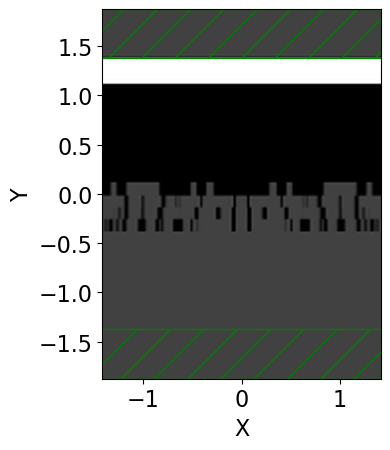

In [2083]:
opt.plot2D()

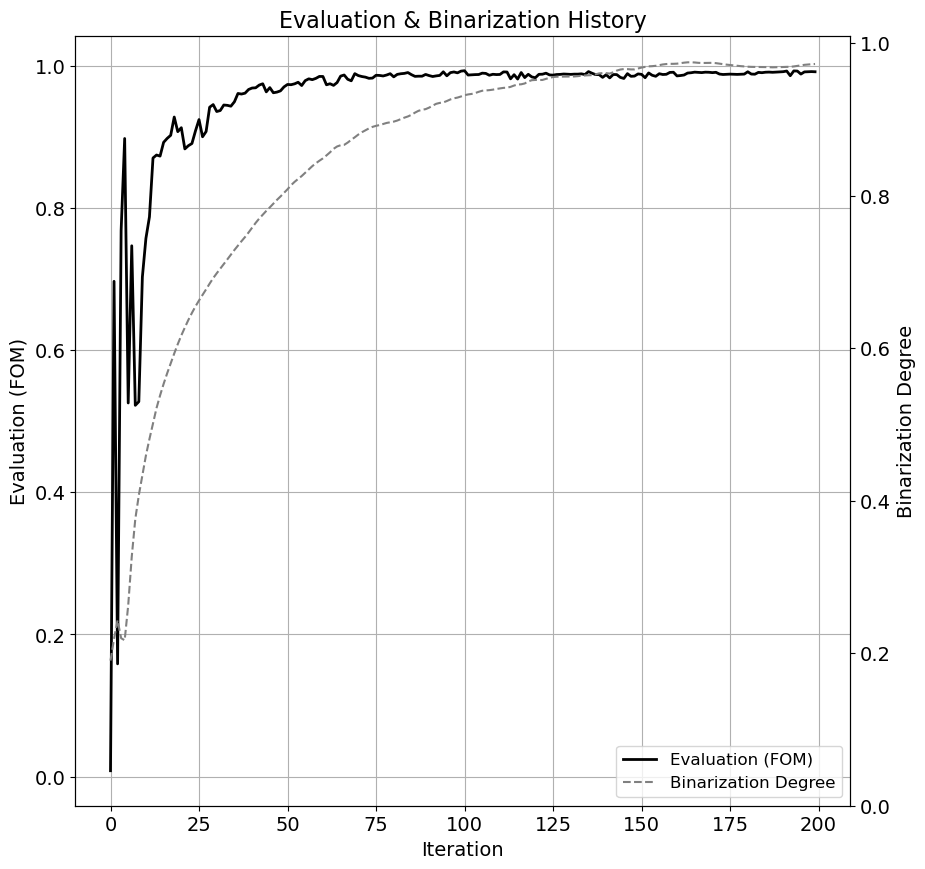

In [2084]:
fig, ax1 = plt.subplots(figsize=(10, 10))

# Title
ax1.set_title("Evaluation & Binarization History", fontsize=16)

# Left y-axis: Evaluation (검정 실선)
ax1.plot(evaluation_history, color="k", linewidth=2, label="Evaluation (FOM)")
ax1.set_xlabel("Iteration", fontsize=14)
ax1.set_ylabel("Evaluation (FOM)", fontsize=14)
ax1.tick_params(axis="both", labelsize=14)

# Right y-axis: Binarization (회색 얇은 점선)
ax2 = ax1.twinx()
ax2.plot(binarization_history, color="0.5", linestyle="--", linewidth=1.5, label="Binarization Degree")
ax2.set_ylabel("Binarization Degree", fontsize=14)
ax2.tick_params(axis="y", labelsize=14)
ax2.set_ylim(0, 1.01)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=12, loc="best")

ax1.grid(True)
plt.show()


In [2085]:
np.savetxt("weights_adam", design_vars.weights)

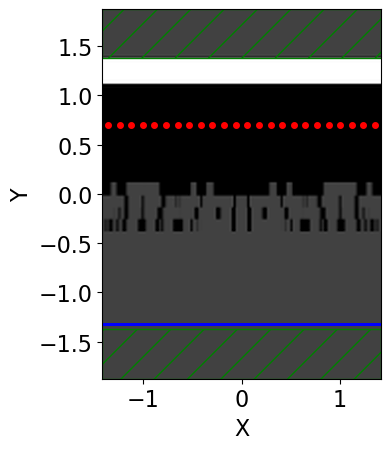

In [2111]:
import math, os
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product
import meep as mp
import meep.adjoint as mpa
from meep.materials import Ag
import matplotlib.pyplot as plt

mp.verbosity(0)
resolution = 50      # px/µm

lambda0 = 0.5            # [um]
fcen    = 1.0 / lambda0  # [1/um]
width = 0.1
fwidth = fcen*width

nfreq   = 1
frequencies = [fcen]

dpml = 0.5
dair = 1.0
hrod = 0.5     

dsub = 1.0
dAg  = 0.25

sx = 2.121                          # +-3차가 +-45도 나옴
sx = 2.828                          # +-4차가 +-45도 나옴
sy = dpml + dair + hrod + dsub + dAg + dpml
cell_size = mp.Vector3(sx, sy)

wrod = sx

Medium1 = mp.Medium(index = 2.0)
Medium2 = mp.Medium(index = 1.0)

pml_layers = [
    mp.PML(direction=mp.Y, thickness=dpml, side=mp.High),
    mp.PML(direction=mp.Y, thickness=dpml, side=mp.Low)
]

DESIGN_W  = wrod
DESIGN_H  = hrod
design_c  = mp.Vector3(0, 0.5*sy - dpml - dAg - dsub - 0.5*hrod)
design_sz = mp.Vector3(DESIGN_W, DESIGN_H)

design_res = resolution
NX = int(DESIGN_W * design_res) + 1


DESIGN_MODE = 'grating'  # or 'free' or 'grating'

if DESIGN_MODE == 'free':
    DESIRED_LAYERS = 1
    NY = int(round(DESIGN_H * design_res)) + 1
else:
    # 해상도와 레이어-패딩 조건을 동시에 만족
    DESIRED_LAYERS = 4       # 원하는 레이어 수 (패딩 1픽셀씩 자동)
    NY_min_layers = 2 * DESIRED_LAYERS - 1        # 레이어 L개 + 패딩 L-1개
    NY_res       = int(round(DESIGN_H * design_res))
    NY = max(NY_res, NY_min_layers)

n_vars = NX * NY

# 최소 피쳐/이진화 설정
MIN_FEATURE = 0.09    # ~80 nm
eta_i = 0.55
beta  = 8
beta_scale = 2
num_beta_steps = 3
filter_radius = mpa.get_conic_radius_from_eta_e(MIN_FEATURE, eta_i)

# x = np.ones((n_vars,), dtype=float) * 0.5
np.random.seed(42)

x = np.random.rand(n_vars) * 0.2 + 0.4

design_vars = mp.MaterialGrid(
    mp.Vector3(NX, NY, 0),
    Medium1, Medium2,
    grid_type="U_MEAN",
)
design_region = mpa.DesignRegion(design_vars, volume=mp.Volume(center=design_c, size=design_sz))

# ----------------------------
# geometry (디자인 포함)
# ----------------------------
geometry = [
    mp.Block(
        material=Ag,
        center=mp.Vector3(0, 0.5*sy - dpml - 0.5*dAg),
        size=mp.Vector3(mp.inf, dAg, mp.inf),
    ),
    # Medium1 bulk (Ag 아래에 위치)
    mp.Block(
        material=Medium1,
        center=mp.Vector3(0, 0.5*sy - dpml - dAg - 0.5*dsub),
        size=mp.Vector3(mp.inf, dsub, mp.inf),
    ),
    # Design block (텍스처 영역)
    mp.Block(
        material=design_vars,
        center=design_region.center,
        size=design_region.size,
    ),
]

src_center_pos = float(0.5*sy - dpml - dAg - dsub - 0.5*hrod+1.5)
src_size   = mp.Vector3(0, 0, 0)

num_sources = 24

src_time_object = mp.GaussianSource(frequency=fcen, fwidth=fwidth, is_integrated=True)
src_component = mp.Ez
# 소스들의 y, z 좌표 기준값 설정
# src_base_center = mp.Vector3(0,src_center_pos,0)
src_base_center = mp.Vector3(0,0.7,0)
src_base_size = mp.Vector3(0, 0, 0)

# --- for loop를 사용하여 소스 리스트 직접 생성 ---
sources = []
if num_sources == 1:
    # 소스가 하나일 경우, 중앙(x=0)에 배치
    center = mp.Vector3(0, src_base_center.y, src_base_center.z)
    sources.append(
        mp.Source(
            src=src_time_object,
            component=src_component,
            center=center,
            size=src_base_size
        )
    )
elif num_sources > 1:
    # 소스 간의 간격(주기) 계산
    period = sx / num_sources
    # 첫 번째 소스의 위치 계산 (전체 배열이 중앙에 오도록)
    start_x = -sx / 2 + period / 2
    
    for i in range(num_sources):
        # 현재 소스의 x 좌표 계산
        x_pos = start_x + i * period
        center = mp.Vector3(x_pos, src_base_center.y, src_base_center.z)
        
        # 계산된 위치에 새로운 소스 객체를 생성하여 리스트에 추가
        sources.append(
            mp.Source(
                src=src_time_object,
                component=src_component,
                center=center,
                size=src_base_size
            )
        )

sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    k_point = mp.Vector3(0,0,0),
    extra_materials=[Ag]
)

bottom_pml_top_y = -0.5 * sy + dpml
tmon_center = mp.Vector3(0, bottom_pml_top_y + (3 / resolution))
tmon_size   = mp.Vector3(sx, 0, 0)                # x방향 한 주기 = sx

k = np.loadtxt("/home/min/EIDL/Tool/Meep/LGD/LGD Project/Mode decomposition/Kyungmin/Personal Project/LGD_Mode_Decomposition_Share/weights_MMA_grat3")
k = np.loadtxt("/home/min/EIDL/Tool/Meep/LGD/LGD Project/Mode decomposition/Kyungmin/Personal Project/LGD_Mode_Decomposition_Share/weights_adam")
design_vars.update_weights(k)

dft_t = sim.add_dft_fields([mp.Ez], fcen, 0, 1, center=tmon_center, size=tmon_size)
flux = sim.add_flux(fcen,          # 중심 주파수
                        0,             # 대역폭 df=0 → 단일 주파수
                        1,             # 샘플 수 1개
                        mp.FluxRegion(center=tmon_center,
                                      size=tmon_size))  # 라인 법선이 +y

plt.figure()
sim.plot2D()
plt.show()

FloatProgress(value=23.0, description='0% done ', max=24.0, min=23.0)

<Axes: xlabel='X', ylabel='Y'>

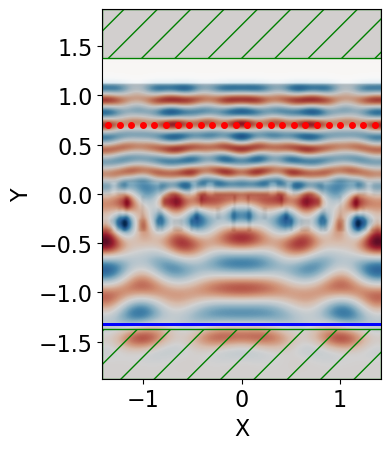

In [2110]:
sim.run(until = 1)
sim.plot2D(fields = mp.Ez)

In [2112]:
sim.run(until_after_sources=mp.stop_when_dft_decayed(1e-3))

In [2113]:
# ===== 유틸: kx 인덱스/값 라벨 + 퍼센트 표시 =====
def annotate_kx_points(ax, kx_vec, y_vec, kx_marks, labels=None,
                       as_index=True,              # True: 인덱스, False: kx 값
                       dy_pts=(-10, -10),
                       show_marker=True,
                       show_percent=False,         # (추가) 퍼센트 표시 여부
                       fft_complex=None,           # (추가) 원본 복소 FFT (있으면 여기서 % 계산)
                       percent_ref=None):          # (추가) 분모(총 전력) override 가능
    """
    - show_percent=True 이고 fft_complex가 주어지면: 각 지점 % = |FFT|^2 / sum(|FFT|^2) * 100
    - show_percent=True 이고 fft_complex가 None이면: y_vec 자체가 이미 [%] 라고 가정
    """
    kx_marks = np.atleast_1d(kx_marks)
    if labels is None:
        labels = [f"kx[{m}]" if as_index else f"kx={m:.3f}" for m in kx_marks]

    # 표시할 인덱스 선택
    idx_list = []
    if as_index:
        for m in kx_marks:
            i = int(np.clip(int(m), 0, len(kx_vec)-1))
            idx_list.append(i)
    else:
        for kv in kx_marks:
            i = int(np.argmin(np.abs(kx_vec - kv)))
            idx_list.append(i)

    # 퍼센트 계산 준비
    if show_percent and (fft_complex is not None):
        # |FFT|^2 기준 총전력
        total_power = np.sum(np.abs(fft_complex)**2) if percent_ref is None else float(percent_ref)

    # 표시 루프
    for i, lab in zip(idx_list, labels):
        x_pt = kx_vec[i]; y_pt = y_vec[i]
        if show_marker:
            ax.scatter([x_pt], [y_pt], s=80, marker='o')

        # 퍼센트 문자열
        if show_percent:
            if fft_complex is not None:
                p_i = np.abs(fft_complex[i])**2
                pct = 100.0 * p_i / (total_power + 1e-30)
            else:
                pct = float(y_pt)  # y_vec이 이미 [%]라고 가정
            lab_full = f"{lab} ({pct:.2f}%)"
        else:
            lab_full = lab

        ax.annotate(lab_full,
                    xy=(x_pt, y_pt),
                    xytext=dy_pts, textcoords="offset points",
                    ha='right', va='top', fontsize=16)

    return idx_list

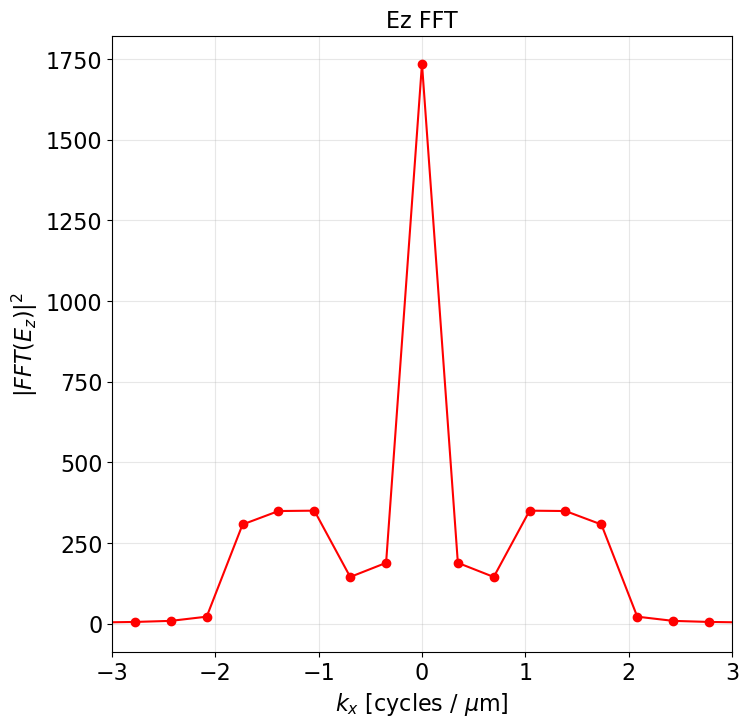

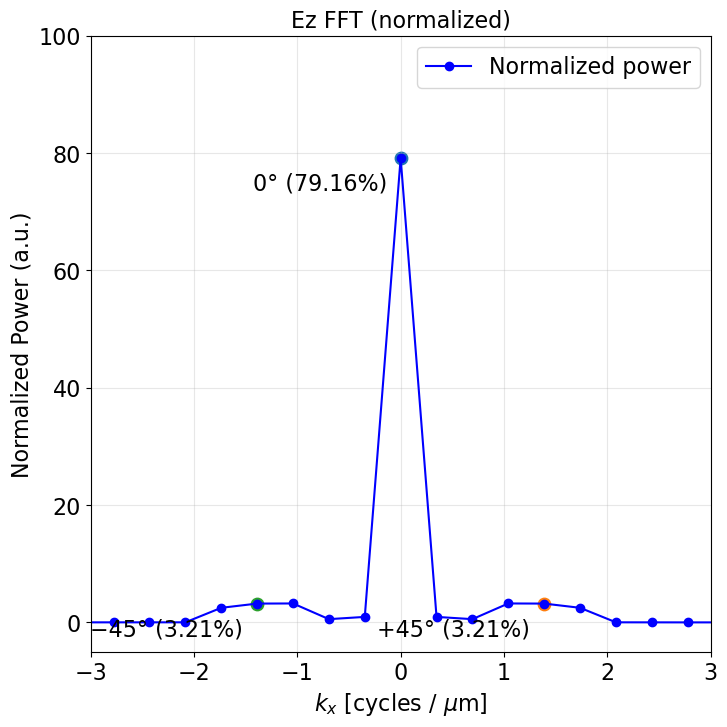

In [2114]:
import matplotlib as mpl
mpl.rcParams.update({
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16
})

Ez_line = np.squeeze(np.array(sim.get_dft_array(dft_t, mp.Ez, 0))).ravel()  # 기존 Ez_line 유지, 1D 보장
fft_Ez  = np.fft.fftshift(np.fft.fft(Ez_line))  # 기존 변수명 유지
kx = np.fft.fftshift(np.fft.fftfreq(len(fft_Ez), d = 1/resolution))

# 찍을 인덱스들 (0, +4, -4 bin)
kx_indices_to_mark = [np.argmin(np.abs(kx)), np.argmin(np.abs(kx))+4, np.argmin(np.abs(kx))-4]
labels_idx = ["0 bin", "+45° bin(+4)", "−45° bin(−4)"]

plt.figure(figsize=(8,8))
plt.plot(kx, np.abs(fft_Ez),'ro-')
ax1 = plt.gca()

plt.xlabel(r"$k_x$ [cycles / $\mu$m]")
plt.ylabel(r"$|FFT(E_z)|^2$")
plt.title("Ez FFT")
plt.grid(True, which="both", alpha=0.3)
plt.xlim(-3,3)
plt.show()

# kx 값으로 직접 지정해도 됨 (as_index=False)
kx_values_to_mark = [0.0, +1.414, -1.414]
labels_val = ["0°", "+45°", "−45°"]

############ 정규화 버전 ############
total_power = np.sum(np.abs(fft_Ez)**2)
normal_fft_Ez = (np.abs(fft_Ez)**2) / (total_power) * 100  # [%]

plt.figure(figsize=(8,8))
plt.plot(kx, normal_fft_Ez, 'bo-', label="Normalized power")
ax2 = plt.gca()

_ = annotate_kx_points(ax2, kx, normal_fft_Ez, kx_values_to_mark,
                       labels=labels_val,
                       as_index=False,          # ← kx 값으로 매칭
                       dy_pts=(-10,-10),
                       show_marker=True,
                       show_percent=True,       # ← 퍼센트 표시 ON
                       fft_complex=None)        # ← y가 이미 [%]이므로 생략

plt.xlabel(r"$k_x$ [cycles / $\mu$m]")
plt.ylabel(r"Normalized Power (a.u.)")
plt.title("Ez FFT (normalized)")
plt.xlim(-3, 3)
plt.ylim(-5, 100)
plt.grid(True, which="both", alpha=0.3)
plt.legend(loc="best")
plt.show()


In [552]:
import numpy as np
import math

def extract_real_sinusoid_from_fft(Ez_line, resolution, kx_target_list, sx=None):
    """
    Ez_line: (N,) 샘플된 Ez(x) (복소 가능)
    kx_target_list: cycles/um 단위의 타겟 kx들. 예) [0.0, +1.414, -1.414]
    resolution: px/um (지금 너가 fftfreq에 d=1/resolution 쓰고 있으니 동일 기준 유지)
    sx: (선택) 주기 길이. 주면 x축도 같이 만들어서 LS 피팅과 비교 가능

    반환: 각 kx_target별로 (idx, kx_bin, C_complex, Acos, Asin, Aamp, phase)
    """

    Ez = np.asarray(Ez_line).ravel()
    N = Ez.size

    # FFT (shift 포함) / 주파수 축(kx, cycles/um)
    F = np.fft.fftshift(np.fft.fft(Ez))
    kx = np.fft.fftshift(np.fft.fftfreq(N, d=1.0 / float(resolution)))

    out = []

    for kx_t in kx_target_list:
        idx = int(np.argmin(np.abs(kx - kx_t)))
        kx_bin = float(kx[idx])

        # 복소 푸리에 계수 (np.fft.fft는 정규화 없음)
        # 시간영역(공간)으로 재구성되는 계수는 C = F/N
        C = F[idx] / N

        # 실수 파형 Re(Ez)에 대한 cos/sin 계수로 해석:
        # Re( C e^{i2πkx x} ) = Re(C)*cos(2πkx x) - Im(C)*sin(2πkx x)
        # 따라서
        Acos = 2.0 * np.real(C)   # 양의 주파수 성분일 때 (kx>0) 대칭 성분을 합친 cos 진폭
        Asin = -2.0 * np.imag(C)  # sin 진폭
        Aamp = math.sqrt(float(Acos**2 + Asin**2))  # 실수 사인파 총 진폭
        phase = math.atan2(float(-Asin), float(Acos))  # cos(·+phi) 형태의 phi (정의 일관용)

        out.append({
            "kx_target": float(kx_t),
            "idx": idx,
            "kx_bin": kx_bin,
            "C_complex": C,
            "Acos": float(Acos),
            "Asin": float(Asin),
            "Aamp": float(Aamp),
            "phase_rad": float(phase),
        })

    return out


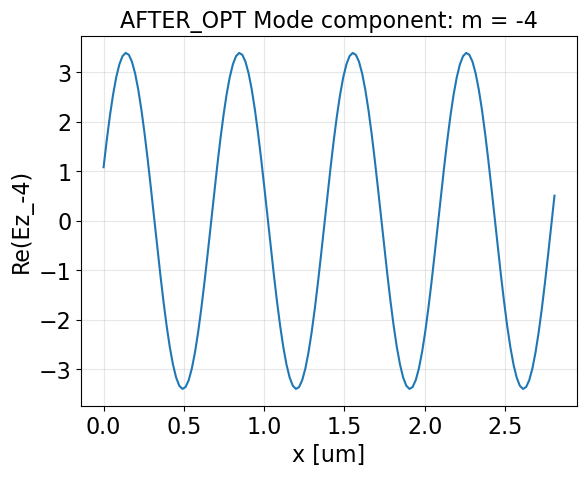

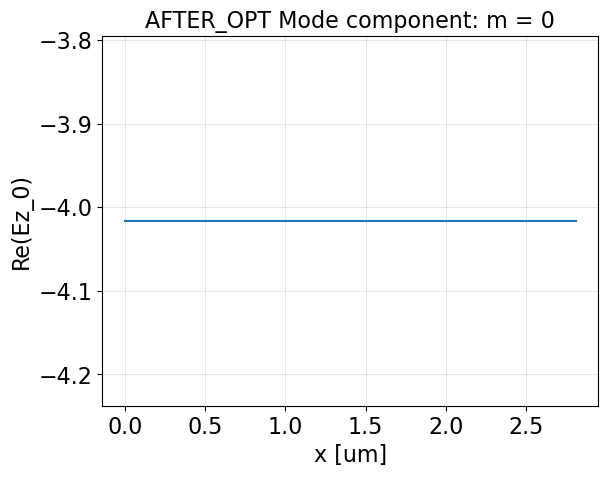

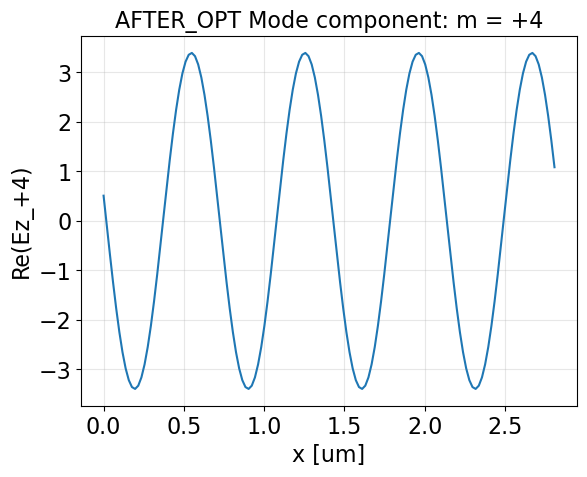

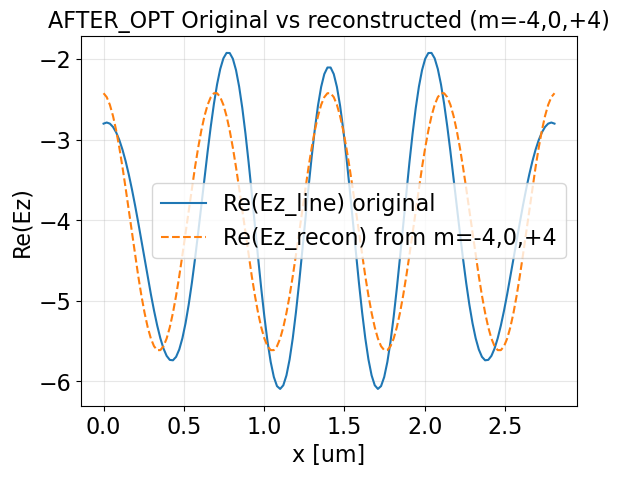


[AFTER_OPT] Extracted complex coeffs:
C(-4) = (1.0849640208577866+3.2172017828028636j)
C( 0) = (-4.016451934693999-9.185626638237228j)
C(+4) = (0.5098197527095149+3.3567272837650997j)
[AFTER_OPT] Intensity ratios within m=-4,0,+4 (|C|^2 normalized): (0.09329300059166991, 0.8134139988166601, 0.09329300059166988)


In [1018]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

def decompose_modes_from_line(Ez_line, sx, m_order, resolution=None):
    """
    Ez_line: 모니터 라인에서 얻은 복소 Ez(x) 샘플 (1D)
    sx     : 주기 길이 [um]
    m_order: 회절차수 (예: 4)

    반환:
      x, Ez_m4, Ez_0, Ez_p4, Ez_recon, (C_m4, C0, C_p4)
    """
    Ez_line = np.asarray(Ez_line).ravel()

    # (권장) 끝점 중복 제거: 길이가 sx*resolution+1이면 마지막 점 제거
    if resolution is not None:
        N_expected = int(round(sx * float(resolution))) + 1
        if Ez_line.size == N_expected:
            Ez_line = Ez_line[:-1]

    N = Ez_line.size
    x = np.linspace(0.0, sx, N, endpoint=False)

    # ---- 푸리에 계수 추출(투영) ----
    # C0  = (1/N) Σ Ez
    # Cp4 = (1/N) Σ Ez * exp(-i2π m x/sx)   ( +m 성분 계수 )
    # Cm4 = (1/N) Σ Ez * exp(+i2π m x/sx)   ( -m 성분 계수 )
    C0  = np.mean(Ez_line)
    Cp4 = np.mean(Ez_line * np.exp(-1j * 2.0 * np.pi * m_order * x / sx))
    Cm4 = np.mean(Ez_line * np.exp(+1j * 2.0 * np.pi * m_order * x / sx))

    # ---- 각 모드 파형 재구성 ----
    Ez_0  = C0  * np.ones_like(x, dtype=np.complex128)
    Ez_p4 = Cp4 * np.exp(+1j * 2.0 * np.pi * m_order * x / sx)
    Ez_m4 = Cm4 * np.exp(-1j * 2.0 * np.pi * m_order * x / sx)

    Ez_recon = Ez_m4 + Ez_0 + Ez_p4

    return x, Ez_m4, Ez_0, Ez_p4, Ez_recon, (Cm4, C0, Cp4)


def plot_mode_waveforms(Ez_line, sx, m_order=4, resolution=None, title_prefix="AFTER"):
    """
    합성 예제처럼 m=-4,0,+4의 Re() 파형을 각각 플롯 + (원 신호 vs 재구성) 비교 플롯
    """
    x, Ez_m4, Ez_0, Ez_p4, Ez_rec, (Cm4, C0, Cp4) = decompose_modes_from_line(
        Ez_line, sx=sx, m_order=m_order, resolution=resolution
    )

    # ---- 각 모드 파형 플롯 ----
    plt.figure()
    plt.plot(x, np.real(Ez_m4))
    plt.xlabel("x [um]")
    plt.ylabel("Re(Ez_-4)")
    plt.title(f"{title_prefix} Mode component: m = -{m_order}")
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure()
    plt.plot(x, np.real(Ez_0))
    plt.xlabel("x [um]")
    plt.ylabel("Re(Ez_0)")
    plt.title(f"{title_prefix} Mode component: m = 0")
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure()
    plt.plot(x, np.real(Ez_p4))
    plt.xlabel("x [um]")
    plt.ylabel("Re(Ez_+4)")
    plt.title(f"{title_prefix} Mode component: m = +{m_order}")
    plt.grid(True, alpha=0.3)
    plt.show()

    # ---- 원 신호 vs (m=-4,0,+4만) 재구성 비교 ----
    plt.figure()
    plt.plot(x, np.real(Ez_line[:len(x)]), label="Re(Ez_line) original")
    plt.plot(x, np.real(Ez_rec), "--", label="Re(Ez_recon) from m=-4,0,+4")
    plt.xlabel("x [um]")
    plt.ylabel("Re(Ez)")
    plt.title(f"{title_prefix} Original vs reconstructed (m=-4,0,+4)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # ---- 계수(복소)와 간단한 intensity 비율 출력 ----
    I_m4 = np.abs(Cm4)**2
    I_0  = np.abs(C0 )**2
    I_p4 = np.abs(Cp4)**2
    It = I_m4 + I_0 + I_p4 + 1e-30
    print(f"\n[{title_prefix}] Extracted complex coeffs:")
    print("C(-4) =", Cm4)
    print("C( 0) =", C0)
    print("C(+4) =", Cp4)
    print(f"[{title_prefix}] Intensity ratios within m=-4,0,+4 (|C|^2 normalized):",
          (I_m4/It, I_0/It, I_p4/It))


# =========================
# 사용 예시 (최적화 '이후' 시뮬에서)
# =========================
# dft_t는 네가 add_dft_fields로 만든 모니터 핸들
Ez_line_after = np.squeeze(np.array(sim.get_dft_array(dft_t, mp.Ez, 0))).ravel()

plot_mode_waveforms(
    Ez_line_after,
    sx=sx,
    m_order=4,
    resolution=resolution,      # 끝점 중복 제거에 사용
    title_prefix="AFTER_OPT"
)

# =========================
# (옵션) 최적화 '이전' 값도 저장해뒀다면 비교 가능
# =========================
# Ez_line_before = ... (최적화 시작 전에 저장한 Ez_line)
# plot_mode_waveforms(Ez_line_before, sx=sx, m_order=4, resolution=resolution, title_prefix="BEFORE_OPT")


In [684]:
Ez_line = np.squeeze(np.array(sim.get_dft_array(dft_t, mp.Ez, 0))).ravel()  # 1D 보장
fft_Ez  = np.fft.fftshift(np.fft.fft(Ez_line))
kx      = np.fft.fftshift(np.fft.fftfreq(len(fft_Ez), d=1/resolution))

# 0 bin 인덱스
i0 = int(np.argmin(np.abs(kx)))

# -4, 0, +4 bin 인덱스
idx_m4 = i0 - 4
idx_0  = i0
idx_p4 = i0 + 4

# 범위 체크(안전)
N = len(fft_Ez)
if not (0 <= idx_m4 < N and 0 <= idx_p4 < N):
    raise IndexError("±4 bin 인덱스가 FFT 범위를 벗어났습니다. (샘플 수/shift 확인 필요)")

# 값(복소수, 크기) 출력
print("m=-4 index:", idx_m4, "kx:", kx[idx_m4], "FFT:", fft_Ez[idx_m4], "|FFT|:", np.abs(fft_Ez[idx_m4]))
print("m= 0 index:", idx_0,  "kx:", kx[idx_0],  "FFT:", fft_Ez[idx_0],  "|FFT|:", np.abs(fft_Ez[idx_0]))
print("m=+4 index:", idx_p4, "kx:", kx[idx_p4], "FFT:", fft_Ez[idx_p4], "|FFT|:", np.abs(fft_Ez[idx_p4]))


m=-4 index: 68 kx: -1.3888888888888888 FFT: (517.3321986864195+37.02405267088308j) |FFT|: 518.6553617518105
m= 0 index: 72 kx: 0.0 FFT: (-1153.6899719270084-870.6691993521316j) |FFT|: 1445.3599572512805
m=+4 index: 76 kx: 1.3888888888888888 FFT: (503.04360087309465+126.29536766854204j) |FFT|: 518.6553617518107
